In [1]:
import argparse
import copy
import math
import os
import random
import typing

import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from dataset import get_dataloader, get_dataset
from EMA import WeightExponentialMovingAverage
from model import DeePMOS_Beta

/Users/lxy/miniforge3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data_path = '../VCC2018/testVCC2/'
id_table = '../VCC2018/id_table/'
#train_set = get_dataset(data_path, "training_data.csv", vcc18=True, idtable=os.path.join(id_table, 'idtable.pkl'))
#valid_set = get_dataset(data_path, "valid_data.csv", vcc18=True, valid=True, idtable=os.path.join(id_table, 'idtable.pkl'))
test_set = get_dataset(data_path, "testing_data.csv", vcc18=True, valid=True, idtable=os.path.join(id_table, 'idtable.pkl'))

In [2]:
data_path = '../BVCC/DATA/'
id_table = '../BVCC/id_table/'
#train_set = get_dataset(data_path, "train", bvcc=True, idtable=os.path.join(id_table, 'idtable.pkl'))
#valid_set = get_dataset(data_path, "valid", bvcc=True, valid=True, idtable=os.path.join(id_table, 'idtable.pkl'))
test_set = get_dataset(data_path, "test", bvcc=True, valid=True, idtable=os.path.join(id_table, 'idtable.pkl'))

In [3]:
#train_loader = get_dataloader(train_set, batch_size=32, num_workers=1)
#valid_loader = get_dataloader(valid_set, batch_size=1, num_workers=1)
test_loader = get_dataloader(test_set, batch_size=1, num_workers=1)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model = DeePMOS_Beta().to(device)
model = torch.load('best-bvcc-beta.pt',map_location=torch.device('cpu'))

# Batch Test

In [ ]:
wavs, filename, _, mos, _ = next(iter(test_loader))
wavs = wavs.to(device)
wavs = wavs.unsqueeze(1)
mos = mos.to(device)

In [ ]:
mos_alpha, mos_beta = model(speech_spectrum = wavs) # shape (batch, seq_len, 1)
mos_alpha = mos_alpha.squeeze() # shape (batch, seq_len)
mos_beta = mos_beta.squeeze()
mos_alpha = torch.mean(mos_alpha, dim = -1) # torch.Size([1])
mos_beta = torch.mean(mos_beta, dim = -1)

In [ ]:
0.98*(mos-1)/4+0.01

In [12]:
mos_mu = mos_alpha/(mos_alpha+mos_beta)
mos_var = (mos_alpha*mos_beta)/((mos_alpha+mos_beta)*(mos_alpha+mos_beta)*(mos_alpha+mos_beta+1))

# Set Test

In [ ]:
mos_alphas = []
mos_betas = []
mos_s = []
mos_means = []
for i, batch in enumerate(tqdm(test_loader, ncols=0, unit=" step")):
    wav, mos, sys_names = batch
    #wav, filename, _, mos, _ = batch
    wav = wav.to(device)
    wav = wav.unsqueeze(1) # shape (batch, 1, seq_len, 257)
    mos = mos.to(device)

    with torch.no_grad():
        mos_alpha, mos_beta = model(speech_spectrum = wav) # shape (batch, seq_len, 1)
        mos_alpha = mos_alpha.squeeze(-1) # shape (batch, seq_len)
        mos_beta = mos_beta.squeeze(-1)
        mos_alpha = torch.mean(mos_alpha, dim = -1) # torch.Size([1])
        mos_beta = torch.mean(mos_beta, dim = -1)
        
        mos_mean = mos_alpha/(mos_alpha+mos_beta)
        #mos_var = (mos_alpha*mos_beta)/((mos_alpha+mos_beta)*(mos_alpha+mos_beta)*(mos_alpha+mos_beta+1))
        mos_mean = mos_mean*4+1 # from range [0,1] to range [1,5]
        #mos_var = mos_var*16 # times 4^2
        
        mos_s.extend(mos.cpu().detach().numpy().tolist())
        mos_alphas.extend(mos_alpha.cpu().detach().numpy().tolist())
        mos_betas.extend(mos_beta.cpu().detach().numpy().tolist())
        mos_means.extend(mos_mean.cpu().detach().numpy().tolist())

In [9]:
from scipy.stats import beta, norm
import matplotlib.pyplot as plt

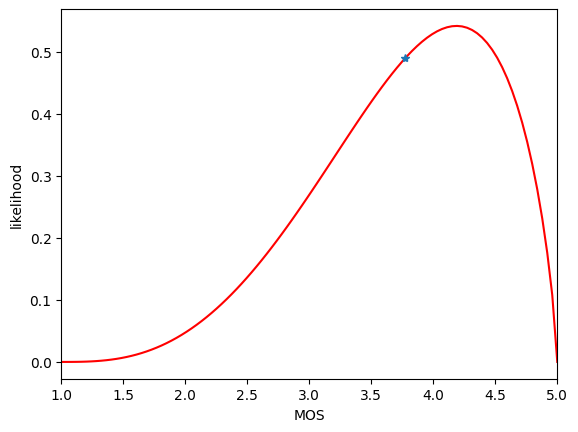

In [20]:
i = 900
a = mos_alphas[i]
b = mos_betas[i]
#mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
x = np.linspace(0,1,100)
plt.xlabel('MOS')
plt.ylabel('likelihood')
plt.plot(x*4+1, beta.pdf(x, a, b)/4,'r-', label='beta pdf')
plt.plot(mos_means[i], beta.pdf((mos_means[i]-1)/4, a, b)/4, '*')
plt.xlim([1, 5])
plt.savefig("figs/dist_test"+str(i)+"_BVCC.png")
plt.show()

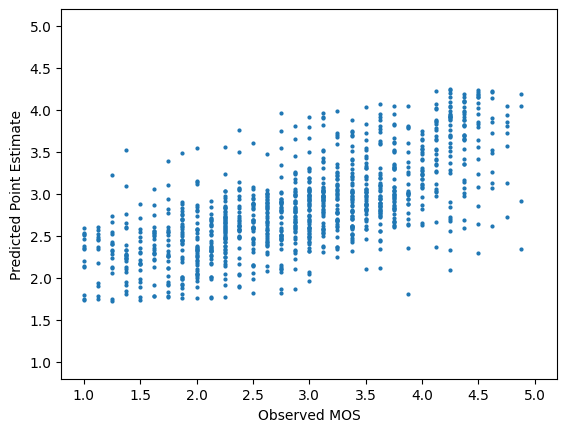

In [10]:
plt.scatter(mos_s, mos_means, s=4)
plt.xlim([0.8,5.2])
plt.ylim([0.8,5.2])
plt.xlabel("Observed MOS")
plt.ylabel("Predicted Point Estimate")
# plt.savefig("figs/MOS_scatter_VCC2018.png")
plt.savefig("figs/MOS_scatter_BVCC.png")

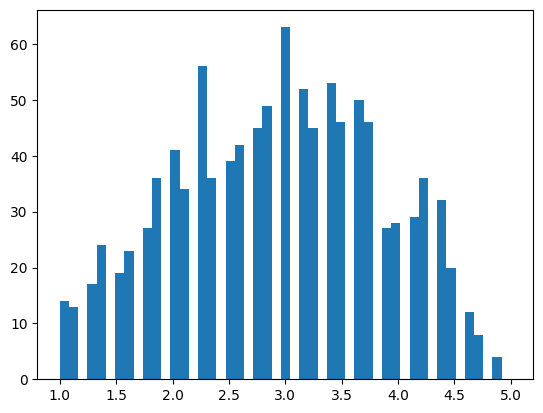

In [12]:
n, bins, patches = plt.hist(x=mos_s, bins=np.linspace(1,5,50))
# plt.savefig("figs/MOS_dis_VCC2018.png")
plt.savefig("figs/MOS_dis_BVCC.png")